In [22]:
import numpy as np
import mne 
import os

mne.viz.set_browser_backend("matplotlib")

'matplotlib'

In [23]:
DATA_ROOT_DIR = "/srv/eeg_reconstruction/shared/emotiv-dataset/hardware-check"

# The number of blocks in a session
NUM_BLOCKS = 16

# The number of times a unique image is repeated to the participant
NUM_REPS = 80

ODDBALL_STIM_VALUE = 100_000
# ODDBALL_STIM_VALUE = 1


In [25]:
def read_edf(subj: int, sess: int, block_index: int):
	"""This function reads the EDF files in the specified blocks and restricts the data to using the recommended method."""
	data_dir = os.path.join(DATA_ROOT_DIR, f"subj_{subj}", f"session_{sess+1:02d}")

	blocks = os.listdir(data_dir)
	blocks.sort()

	block = blocks[block_index]
	edf_file = None

	for item in os.listdir(os.path.join(data_dir, block)):
		if item.endswith("edf"):
			edf_file = os.path.join(data_dir, block, item)
			
	# print(edf_file)
	raw = mne.io.read_raw_edf(edf_file, preload=True)
	montage = mne.channels.make_standard_montage('standard_1020')
	eeg_channels = ['Cz',
	'Fp1',
	'F7',
	'F3',
	'CP5',
	'CP1',
	'P1',
	'P3',
	'P5',
	'P7',
	'PO9',
	'PO7',
	'PO3',
	'O1',
	'O9',
	'Pz',
	'POz',
	'Oz',
	'O10',
	'O2',
	'PO4',
	'PO8',
	'PO10',
	'P8',
	'P6',
	'P4',
	'P2',
	'CP2',
	'CP6',
	'F4',
	'F8',
	'Fp2']

	# Restrict data to only these EEG channels using the new recommended method
	raw.pick(eeg_channels)
	raw.set_montage(montage)
 
	return raw

def filter_unwanted_events(events, event_id):
	"""This function returns the events, filtering out behaviour and oddball events.
	"""

	# Create dictionaries for stimulus and behavior event IDs
	code_to_desc = {v: k for k, v in event_id.items()}
 
	idx_target = []
	for i in range(len(events)):
		event_code = events[i, 2]

		event_desc = code_to_desc[event_code]
		event_desc_split = event_desc.split(",")
		label = event_desc_split[0]
		value = int(event_desc_split[1])
		if label == "behav":
			if event_desc in event_id:
				del event_id[event_desc] 
			idx_target.append(i)
		elif label == "oddball" or value == ODDBALL_STIM_VALUE:
			if event_desc in event_id:
				del event_id[event_desc] 
			idx_target.append(i)
			
	filtered_events = np.delete(events, idx_target, 0)

	return filtered_events, event_id 

def handle_simultaneous_events(events, event_id, sfreq: int):
    """This function edits the time of events that occur simultaneous so they can be epoched."""
    # Deal with random event time collisions
    from collections import defaultdict
    simultaneous_events = defaultdict(list)	

    for index in range(len(events)):
        onset_time = events[index, 0]
        simultaneous_events[onset_time].append(index)

    simultaneous_events = {time: indices for time, indices in simultaneous_events.items() if len(indices) > 1}
    print(simultaneous_events)
    for onset_time, event_indices in simultaneous_events.items():
        # if there is a collision between events, space them out forwards by 200 ms.
        COLLISION_GAP_S = 0.2
        COLLISION_GAP_TIME_POINTS = COLLISION_GAP_S * sfreq
        time_offset = 0

        for index in event_indices:
            events[index, 0] = onset_time + time_offset
            time_offset += COLLISION_GAP_TIME_POINTS
            
    return events, event_id

In [26]:
def epoching2():
    subj: int = 1  # 1-indexed
    sess: int = 2  # 0-indexed
    
    raws = [read_edf(subj, sess, index) for index in range(NUM_BLOCKS)]
    raw = mne.concatenate_raws(raws)
    del raws
    
    # events: [time, 0, event_code]
    # event_id: {"label,value,-1,index": event_code}
    events, event_id = mne.events_from_annotations(raw)

    # Get rid of behavioural and oddball events
    events, event_id = filter_unwanted_events(events, event_id)

    # Handle simultaneous onset time events
    events, event_id = handle_simultaneous_events(events, event_id, raw.info["sfreq"])
    
    img_cond_set = set()
    # Track the image conditions used in the data
    for event_desc in event_id.keys():
        img_cond_id = int(event_desc.split(",")[1])
        img_cond_set.add(img_cond_id)

    ### Epoching, baseline correction and resampling ###
    epochs = mne.Epochs(raw, events, event_id=event_id, tmin=-.2, tmax=1.0, baseline=(None,0),
            preload=True, reject=None, reject_by_annotation=None)
    # del raw
    
    epochs.resample(250)
    
    return epochs, img_cond_set, events, event_id, raw

epochs, img_cond_set, events, event_id, raw = epoching2()

Extracting EDF parameters from /srv/eeg_reconstruction/shared/emotiv-dataset/hardware-check/subj_1/session_03/block_01/Subject 1, Session 3, Block 1 Recording_FLEX2_213075_2024.08.14T15.43.51.04.00.md.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 63743  =      0.000 ...   248.996 secs...
Extracting EDF parameters from /srv/eeg_reconstruction/shared/emotiv-dataset/hardware-check/subj_1/session_03/block_02/Subject 1, Session 3, Block 2 Recording_FLEX2_213075_2024.08.14T15.48.05.04.00.md.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 64511  =      0.000 ...   251.996 secs...
Extracting EDF parameters from /srv/eeg_reconstruction/shared/emotiv-dataset/hardware-check/subj_1/session_03/block_03/Subject 1, Session 3, Block 3 Recording_FLEX2_213075_2024.08.14T15.52.26.04.00.md.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6

/tmp/ipykernel_491106/414875027.py:16: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
/tmp/ipykernel_491106/414875027.py:16: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
/tmp/ipykernel_491106/414875027.py:16: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Extracting EDF parameters from /srv/eeg_reconstruction/shared/emotiv-dataset/hardware-check/subj_1/session_03/block_05/Subject 1, Session 3, Block 5 Recording_FLEX2_213075_2024.08.14T16.01.11.04.00.md.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 69375  =      0.000 ...   270.996 secs...
Extracting EDF parameters from /srv/eeg_reconstruction/shared/emotiv-dataset/hardware-check/subj_1/session_03/block_06/Subject 1, Session 3, Block 6 Recording_FLEX2_213075_2024.08.14T16.06.29.04.00.md.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 74751  =      0.000 ...   291.996 secs...


/tmp/ipykernel_491106/414875027.py:16: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
/tmp/ipykernel_491106/414875027.py:16: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Extracting EDF parameters from /srv/eeg_reconstruction/shared/emotiv-dataset/hardware-check/subj_1/session_03/block_07/Subject 1, Session 3, Block 7 Recording_FLEX2_213075_2024.08.14T16.12.08.04.00.md.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 75519  =      0.000 ...   294.996 secs...
Extracting EDF parameters from /srv/eeg_reconstruction/shared/emotiv-dataset/hardware-check/subj_1/session_03/block_08/Subject 1, Session 3, Block 8 Recording_FLEX2_213075_2024.08.14T16.17.13.04.00.md.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 62719  =      0.000 ...   244.996 secs...
Extracting EDF parameters from /srv/eeg_reconstruction/shared/emotiv-dataset/hardware-check/subj_1/session_03/block_09/Subject 1, Session 3, Block 9 Recording_FLEX2_213075_2024.08.14T16.21.25.04.00.md.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6

/tmp/ipykernel_491106/414875027.py:16: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
/tmp/ipykernel_491106/414875027.py:16: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Extracting EDF parameters from /srv/eeg_reconstruction/shared/emotiv-dataset/hardware-check/subj_1/session_03/block_11/Subject 1, Session 3, Block 11 Recording_FLEX2_213075_2024.08.14T16.30.01.04.00.md.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 62975  =      0.000 ...   245.996 secs...
Extracting EDF parameters from /srv/eeg_reconstruction/shared/emotiv-dataset/hardware-check/subj_1/session_03/block_12/Subject 1, Session 3, Block 12 Recording_FLEX2_213075_2024.08.14T16.34.22.04.00.md.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 64255  =      0.000 ...   250.996 secs...


/tmp/ipykernel_491106/414875027.py:16: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
/tmp/ipykernel_491106/414875027.py:16: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Extracting EDF parameters from /srv/eeg_reconstruction/shared/emotiv-dataset/hardware-check/subj_1/session_03/block_13/Subject 1, Session 3, Block 13 Recording_FLEX2_213075_2024.08.14T16.38.41.04.00.md.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 63231  =      0.000 ...   246.996 secs...
Extracting EDF parameters from /srv/eeg_reconstruction/shared/emotiv-dataset/hardware-check/subj_1/session_03/block_14/Subject 1, Session 3, Block 14 Recording_FLEX2_213075_2024.08.14T16.42.55.04.00.md.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 63231  =      0.000 ...   246.996 secs...


/tmp/ipykernel_491106/414875027.py:16: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
/tmp/ipykernel_491106/414875027.py:16: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Extracting EDF parameters from /srv/eeg_reconstruction/shared/emotiv-dataset/hardware-check/subj_1/session_03/block_15/Subject 1, Session 3, Block 15 Recording_FLEX2_213075_2024.08.14T16.47.09.04.00.md.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 64767  =      0.000 ...   252.996 secs...
Extracting EDF parameters from /srv/eeg_reconstruction/shared/emotiv-dataset/hardware-check/subj_1/session_03/block_16/Subject 1, Session 3, Block 16 Recording_FLEX2_213075_2024.08.14T16.51.30.04.00.md.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 63231  =      0.000 ...   246.996 secs...


/tmp/ipykernel_491106/414875027.py:16: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
/tmp/ipykernel_491106/414875027.py:16: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
/tmp/ipykernel_491106/414875027.py:16: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Used Annotations descriptions: ['behav,0,-1,1031', 'behav,0,-1,1042', 'behav,0,-1,106', 'behav,0,-1,111', 'behav,0,-1,129', 'behav,0,-1,169', 'behav,0,-1,170', 'behav,0,-1,192', 'behav,0,-1,214', 'behav,0,-1,217', 'behav,0,-1,22', 'behav,0,-1,233', 'behav,0,-1,235', 'behav,0,-1,236', 'behav,0,-1,263', 'behav,0,-1,265', 'behav,0,-1,285', 'behav,0,-1,303', 'behav,0,-1,309', 'behav,0,-1,328', 'behav,0,-1,331', 'behav,0,-1,342', 'behav,0,-1,344', 'behav,0,-1,346', 'behav,0,-1,385', 'behav,0,-1,389', 'behav,0,-1,43', 'behav,0,-1,431', 'behav,0,-1,451', 'behav,0,-1,453', 'behav,0,-1,500', 'behav,0,-1,514', 'behav,0,-1,517', 'behav,0,-1,535', 'behav,0,-1,562', 'behav,0,-1,596', 'behav,0,-1,620', 'behav,0,-1,644', 'behav,0,-1,65', 'behav,0,-1,690', 'behav,0,-1,746', 'behav,0,-1,747', 'behav,0,-1,767', 'behav,0,-1,788', 'behav,0,-1,792', 'behav,0,-1,796', 'behav,0,-1,818', 'behav,0,-1,831', 'behav,0,-1,840', 'behav,0,-1,85', 'behav,0,-1,852', 'behav,0,-1,869', 'behav,0,-1,870', 'behav,0,-1,877'

No projector specified for this dataset. Please consider the method self.add_proj.


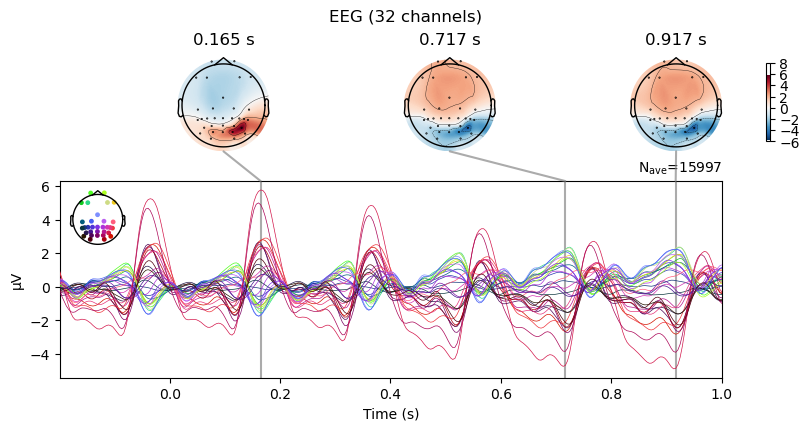

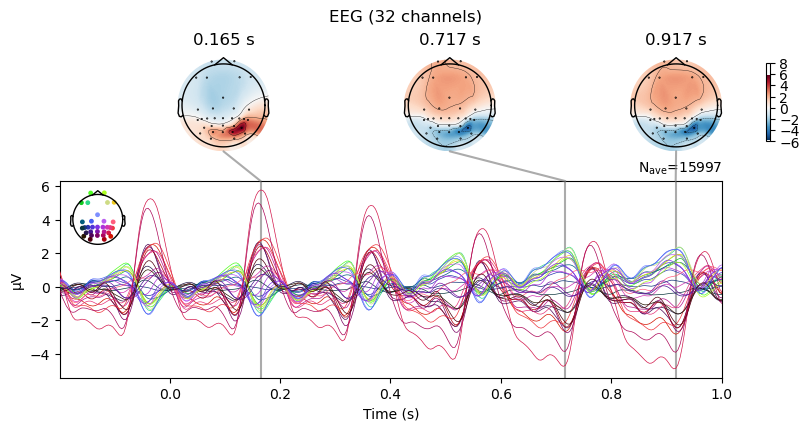

In [30]:
epochs.average().plot_joint(picks="eeg")
# epochs.average().plot_topomap(times=[0.0, 0.08, 0.1, 0.12, 0.2], ch_type="eeg")

In [42]:
# Identify TOO_SHORT epochs
too_short_indices = [i for i, reason in enumerate(epochs.drop_log) if 'TOO_SHORT' in reason]

# Get the events corresponding to these epochs
too_short_events = events[too_short_indices]
code_to_desc = {v: k for k, v in event_id.items()}

# Inspect the length of each TOO_SHORT epoch
for event in too_short_events:
    event_time = event[0] / raw.info['sfreq']
    start_time = event_time + -0.2
    end_time = event_time + 1.0

    start_sample = max(int(start_time * raw.info['sfreq']), 0)
    end_sample = min(int(end_time * raw.info['sfreq']), len(raw.times) - 1)

    actual_length = (end_sample - start_sample) / raw.info['sfreq']
    print(f"Event at {event_time:.2f}s: Actual epoch length = {actual_length:.2f}s {code_to_desc[event[-1]]}")

Event at 4093.16s: Actual epoch length = 1.04s stim,125725,-1,251
Event at 4093.36s: Actual epoch length = 0.84s stim,394008,-1,252
Event at 4093.56s: Actual epoch length = 0.64s stim,101952,-1,253


In [40]:
def epoching3(epochs, img_cond_set, events, event_id):
    ch_names = epochs.info['ch_names']
    times = epochs.times
    data = epochs.get_data()
    img_cond = list(img_cond_set)
    # del epochs

    code_to_desc = {v: k for k, v in event_id.items()}
    
    # Find the indices of TOO_SHORT epochs
    too_short_indices = [i for i, reason in enumerate(epochs.drop_log) if 'TOO_SHORT' in reason]
    too_short_events = events[too_short_indices]

    # List to store duplicated rows
    duplicated_rows = []

    for too_short_event in too_short_events:
        too_short_desc_part = code_to_desc[too_short_event[2]].split(",")[1]

        for i, event in enumerate(events):
            if code_to_desc[event[2]].split(",")[1] == too_short_desc_part:
                duplicated_rows.append(data[i])
                break

    duplicated_rows = np.array(duplicated_rows)

    # Combine original epoch data with duplicated rows
    data = np.concatenate([data, duplicated_rows], axis=0)

    # Update the events array to match the new data length
    events = np.delete(events, too_short_indices, axis=0)
    events = np.vstack([events, too_short_events])
    print(events.shape)
    
    # Sorted data matrix of shape:
    # Image conditions × EEG repetitions × EEG channels × EEG time points
    sorted_data = np.zeros((len(img_cond), NUM_REPS, data.shape[1],
        data.shape[2]))
    for i in range(len(img_cond)):
        # Find the indices of the selected image condition
        idx = []
        for index in range(len(events)):
            event_desc = code_to_desc[events[index, 2]]
            value = int(event_desc.split(",")[1])
            
            if value == img_cond[i]:
                idx.append(index)
        # Randomly select only the max number of EEG repetitions
        x = data[np.ix_(idx)]

        sorted_data[i] = x
    del data

    # ignore the first 50 time points.
    epoched_data = sorted_data[:, :, :, 50:300]
    del sorted_data

    return epoched_data, img_cond, ch_names, times[50:300]

epoched_data, img_cond, ch_names, times = epoching3(epochs, img_cond_set, events, event_id)

/tmp/ipykernel_491106/742261499.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


(16000, 3)


In [41]:
epoched_data.shape
# Image conditions × EEG repetitions × EEG channels × EEG time points


(200, 80, 32, 250)

In [43]:
raw_average_epoched_data = np.mean(np.array(epoched_data), axis=1)
raw_average_epoched_data.shape

(200, 32, 250)

250


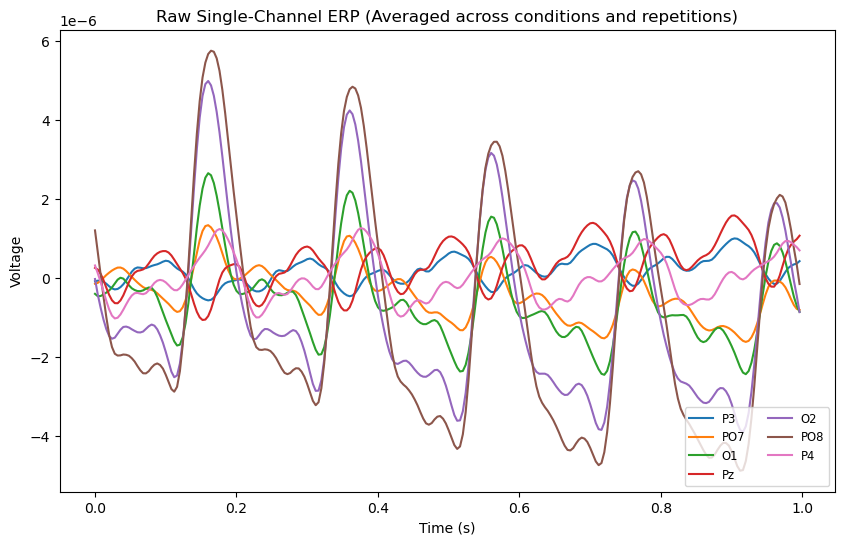

In [65]:
import matplotlib.pyplot as plt


data = np.mean(raw_average_epoched_data, axis=0)
electrodes = ('O1', 'O2', 'PO7', 'PO8', 'Pz', 'P3', 'P4')

# Create the plot
plt.figure(figsize=(10, 6))

times = list(map(lambda x: x/250, range(250)))

for i in np.where(np.isin(ch_names, electrodes))[0]:
# for i in range(32):
    plt.plot(times, data[i], label=ch_names[i])  # Plot each row as a separate line

plt.xlabel('Time (s)')
plt.ylabel('Voltage')
plt.title('Raw Single-Channel ERP (Averaged across conditions and repetitions)')

plt.legend(loc='lower right', fontsize='small', ncol=2)

plt.show()


(250,)


/tmp/ipykernel_491106/2803551072.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right', fontsize='small', ncol=2)


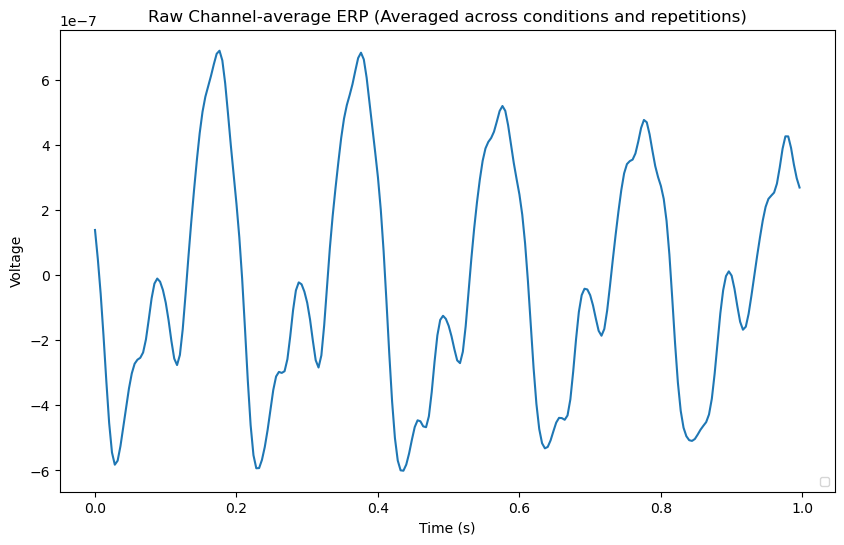

In [67]:
channel_average_epoched_data = np.mean(raw_average_epoched_data, axis=1)
data = np.mean(channel_average_epoched_data, axis=0)
print(data.shape)
plt.figure(figsize=(10, 6))

plt.plot(times, data)  # Plot each row as a separate line

plt.xlabel('Time (s)')
plt.ylabel('Voltage')
plt.title('Raw Channel-average ERP (Averaged across conditions and repetitions)')

plt.legend(loc='lower right', fontsize='small', ncol=2)

plt.show()


In [ ]:
def epoching3(epochs, img_cond_set, events, event_id):
    ch_names = epochs.info['ch_names']
    times = epochs.times
    data = epochs.get_data()
    img_cond = list(img_cond_set)
    # del epochs

    code_to_desc = {v: k for k, v in event_id.items()}
    
    # GET RID OF TOO_SHORT EPOCHS
    # Find the indices of TOO_SHORT epochs
    too_short_indices = [i for i, reason in enumerate(epochs.drop_log) if 'TOO_SHORT' in reason]
    too_short_events = events[too_short_indices]

    # List to store duplicated rows
    duplicated_rows = []

    for too_short_event in too_short_events:
        too_short_desc_part = code_to_desc[too_short_event[2]].split(",")[1]

        for i, event in enumerate(events):
            if code_to_desc[event[2]].split(",")[1] == too_short_desc_part:
                duplicated_rows.append(data[i])
                break

    duplicated_rows = np.array(duplicated_rows)

    # Combine original epoch data with duplicated rows
    data = np.concatenate([data, duplicated_rows], axis=0)

    # Update the events array to match the new data length
    events = np.delete(events, too_short_indices, axis=0)
    events = np.vstack([events, too_short_events])
    # ----------------------------
    
    # Sorted data matrix of shape:
    # Image conditions × EEG repetitions × EEG channels × EEG time points
    sorted_data = np.zeros((len(img_cond), NUM_REPS, data.shape[1],
        data.shape[2]))
    for i in range(len(img_cond)):
        # Find the indices of the selected image condition
        idx = []
        for index in range(len(events)):
            event_desc = code_to_desc[events[index, 2]]
            value = int(event_desc.split(",")[1])
            
            if value == img_cond[i]:
                idx.append(index)
        # Randomly select only the max number of EEG repetitions
        x = data[np.ix_(idx)]

        sorted_data[i] = x
    del data

    # ignore the first 50 time points.
    epoched_data = sorted_data[:, :, :, 50:300]
    del sorted_data

    return epoched_data, img_cond, ch_names, times[50:300]

epoched_data, img_cond, ch_names, times = epoching3(epochs, img_cond_set, events, event_id)

/tmp/ipykernel_491106/742261499.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


(16000, 3)


In [45]:
def mvnn(epoched_train):
    """Compute the covariance matrices of the EEG data (calculated for each
    time-point or epoch/repetitions of each image condition), and then average
    them across image conditions. The inverse of the
    resulting averaged covariance matrix is used to whiten the EEG data
    (independently for each session).
    
    zero-score standardization also has well performance

    Parameters
    ----------
    args : Namespace
        Input arguments.
    epoched_train : list of floats
        Epoched training EEG data.

    Returns
    -------
    whitened_train : list of float
        Whitened training EEG data.

    """
    from tqdm import tqdm
    from sklearn.discriminant_analysis import _cov
    import scipy

    
    #  covariance matrix of shape:
    # Data partitions × EEG channels × EEG channels
    n_conditions, n_reps, n_channels, _ = epoched_train.shape
    
    # Image conditions covariance matrix of shape:
    # Image conditions × EEG channels × EEG channels
    sigma_cond = np.empty((n_conditions,
        n_channels, n_channels))
    
    for i in tqdm(range(epoched_train.shape[0])):
        # EEG repetitions × EEG channels × EEG time points
        cond_data = epoched_train[i]
        
        # Compute covariance matrices at each epoch (EEG repetition),
        # and then average across epochs/repetitions
        sigma_cond[i] = np.mean([_cov(np.transpose(cond_data[e]),
            shrinkage='auto') for e in range(n_reps)],
            axis=0)
            
    # Average the covariance matrices across image conditions
    sigma_tot = sigma_cond.mean(axis=0)
    
    # Compute the inverse of the covariance matrix
    sigma_inv = scipy.linalg.fractional_matrix_power(sigma_tot, -0.5)

    ### Whiten the data ###
    whitened_train = np.reshape(
        (np.reshape(epoched_train, (-1, epoched_train.shape[2], epoched_train.shape[3]))
            .swapaxes(1, 2) @ sigma_inv)
            .swapaxes(1, 2), epoched_train.shape
    )


    ### Output ###
    return whitened_train
whitened_data = mvnn(epoched_data)

100%|██████████| 200/200 [00:09<00:00, 21.01it/s]


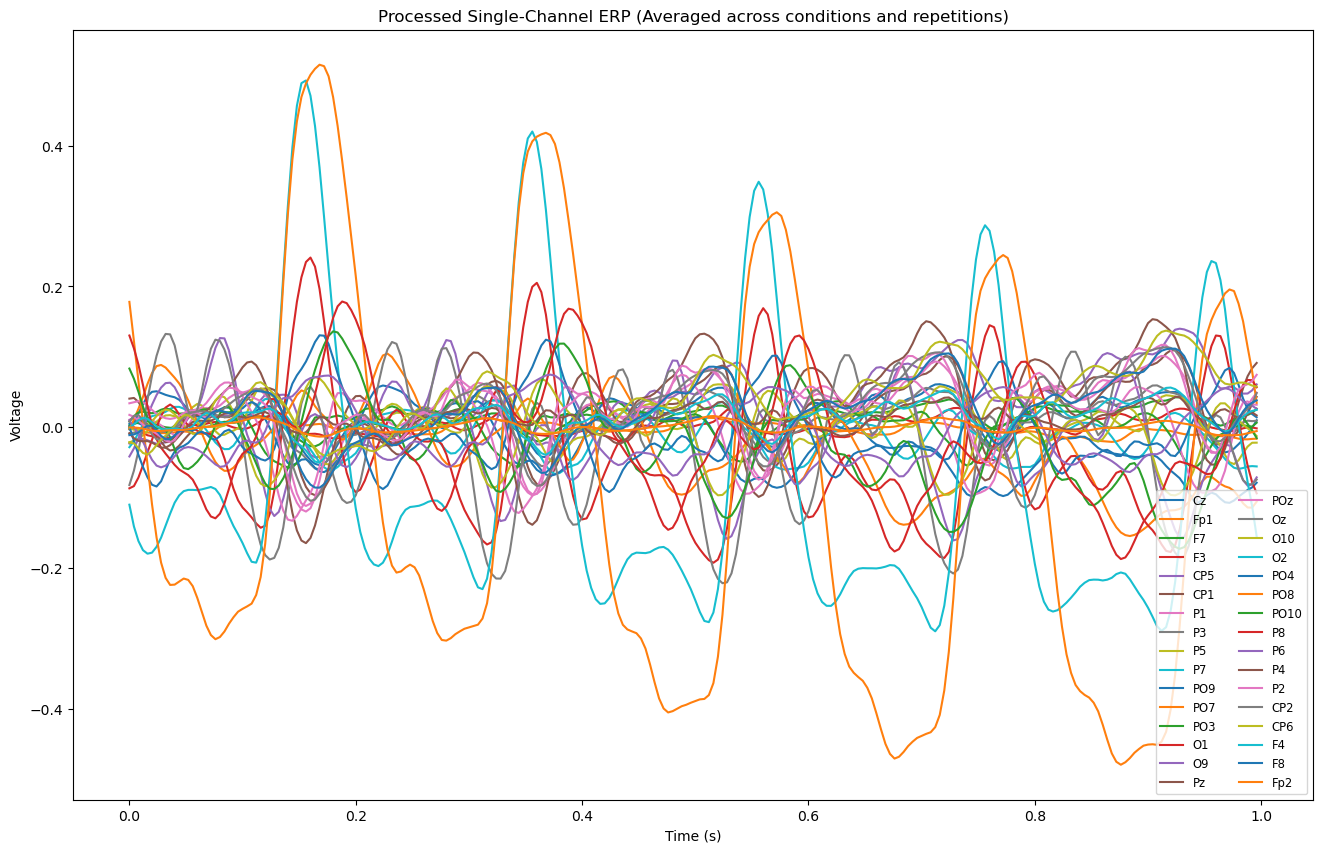

In [46]:
averaged_whitened_data = np.mean(np.array(whitened_data), axis=1)

data = np.mean(averaged_whitened_data, axis=0)

# Create the plot
plt.figure(figsize=(16, 10))

for i in range(32):
    plt.plot(times, data[i], label=ch_names[i])  # Plot each row as a separate line

plt.xlabel('Time (s)')
plt.ylabel('Voltage')
plt.title('Processed Single-Channel ERP (Averaged across conditions and repetitions)')

plt.legend(loc='lower right', fontsize='small', ncol=2)

plt.show()


In [47]:
def save_prepr(white_data, ch_names, times):
    """Reshaping the data to the format:
    Image conditions × EGG repetitions × EEG channels × EEG time points.
    Then, the data of the training EEG is saved.

    Parameters
    ----------
    args : Namespace
        Input arguments.
    whitened_train : list of float
        Whitened training EEG data.
    ch_names : list of str
        EEG channel names.
    times : float
        EEG time points.

    """

    import pickle


    save_dir = os.path.join("/srv/eeg_reconstruction/shared/emotiv-dataset/hardware-check",
        'Preprocessed_data_250Hz', f'sub-{1:02d}')
    file_name_train = 'preprocessed_eeg_training.npy'
        
    # Insert the data into a dictionary
    train_dict = {
        'preprocessed_eeg_data': white_data,
        'ch_names': ch_names,
        'times': times
    }
    # Create the directory if not existing and save the data
    if os.path.isdir(save_dir) == False:
        os.makedirs(save_dir)
        
    # np.save(os.path.join(save_dir, file_name_train),
    #     train_dict)
    save_pic = open(os.path.join(save_dir, file_name_train), 'wb')
    pickle.dump(train_dict, save_pic, protocol=4)
    save_pic.close()
    del train_dict
save_prepr(whitened_data, ch_names, times)